In [1]:
!pip install meditorch
!pip install torchsummary

     |████████████████████████████████| 77 kB 3.3 MB/s  eta 0:00:01


# **EDD**

**1.Downloading data and extracting files to ./EDD2020**

In [2]:
#ACCEPT COMPETITION RULES TO ACCESS DATA at https://edd2020.grand-challenge.org/
import zipfile
with zipfile.ZipFile('EDD2020.zip', 'r') as zip_ref:
    
    zip_ref.extractall('EDD2020')
!ls ./EDD2020/EDD2020_release-I_2020-01-15

Data you are downloading is protected under: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
see: https://creativecommons.org/licenses/by-nc/4.0/
downloading... wait!!!
done... good luck with the EDD2020 challenge!!!
EDD_readme.md	bbox		masks	       originalImages
EDD_readme.pdf	class_list.txt	masksPerClass


In [3]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# %matplotlib inline
# img = cv2.imread('./EDD2020/EDD2020_release-I_2020-01-15/originalImages/EDD2020_ACB0000.jpg')
# img = img[:,:,::-1]
# #img = img[::-1,:,:]#flipping image
# plt.imshow(img)
# plt.show()
# np.asarray(img).shape

In [4]:
def resize_my_images(src,dst,is_masks):
    import cv2
    import os
    import numpy as np

    i = 0
    img_size = 224
    path = src
    for img_name in sorted(os.listdir(path)):
        img = None
#         print(img_name)
        try:
            if not is_masks:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif is_masks:
                img = cv2.imread(os.path.join(path, img_name),cv2.IMREAD_GRAYSCALE)
    
            h, w = img.shape[:2]
            a1 = w/h
            a2 = h/w

            if(a1 > a2):
                #print('a1 > a2')
                # if width greater than height
                r_img = cv2.resize(img, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
                margin = int(r_img.shape[1]/6)
                crop_img = r_img[0:img_size, margin:(margin+img_size)]

            elif(a1 < a2):
                #print('a1 < a2')
                # if height greater than width
                r_img = cv2.resize(img, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
                margin = int(r_img.shape[0]/6)
                crop_img = r_img[margin:(margin+img_size), 0:img_size]

            elif(a1 == a2):
                #print('a1== a2')
                # if height and width are equal
                r_img = cv2.resize(img, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
                crop_img = r_img[0:img_size, 0:img_size]

            if(crop_img.shape[0] != img_size or crop_img.shape[1] != img_size):
                #print('someting....')
                crop_img = r_img[0:img_size, 0:img_size]

            if(crop_img.shape[0] == img_size and crop_img.shape[1] == img_size):
                if not is_masks:
                    cv2.imwrite(dst + img_name, crop_img[:,:,::-1])#SAVING AS RGB FORMAT 
                    #display_image(crop_img[:,:,::-1],is_mask=False)
                elif is_masks:
                    #converting masks: tif--->jpg   
                    cv2.imwrite(dst + img_name.split('.')[0]+'.jpg', crop_img)
                    #display_image(crop_img,is_mask=True)
                #print("Saving "+ img_name.split('.')[0] + " with dims: " + str(crop_img.shape))
                i += 1
            #print('><'*20)
        except:
            print('Could not save image.')
    if is_masks:
        print('no of masks saved: ',i)
    else:
        print('no of images saved: ',i)

In [5]:
!rm -rf ./EDD2020/resized_masks/
!mkdir ./EDD2020/resized_masks/
resize_my_images('./EDD2020/EDD2020_release-I_2020-01-15/masks/','./EDD2020/resized_masks/',is_masks=True)

no of masks saved:  502


In [6]:
!rm -rf ./EDD2020/resized_images/
!mkdir ./EDD2020/resized_images/
resize_my_images('./EDD2020/EDD2020_release-I_2020-01-15/originalImages/','./EDD2020/resized_images/',is_masks=False)

no of images saved:  386


### Note: no of masks = 502, no of images=386.   
Some images have more than 1 conditions-- BE,suspicious,HGD,cancer,polyp

**2.Defining class for preparing the dataset and other utility functions**




In [7]:
#img= Image.open('./EDD2020/resized_masks/EDD2020_ACB0000_cancer.tif')
def display_image(img,is_mask=False):
    from matplotlib import pyplot as plt
    %matplotlib inline
    if is_mask:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.show()
#img = cv2.imread('./EDD2020/resized_masks/EDD2020_ACB0000_cancer.jpg',cv2.IMREAD_GRAYSCALE)
# display_image(img,True)

In [45]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import os
import numpy as np
import glob
from PIL import Image
from skimage.transform import resize

def load_image(path,is_mask):
    if not is_mask:
        return np.asarray(Image.open(path).convert("RGB"))
    else:
        return np.asarray(Image.open(path).convert('L'))

def load_set(folder,is_mask,shuffle=False):
    data = []
    img_list = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    if shuffle:
        np.random.shuffle(img_list)
    for img_fn in img_list:
        img = load_image(img_fn,is_mask)
        data.append(img)
    return data, img_list

class EDD(Dataset):
    '''
    Class for preparing the EDD2020 dataset
    '''
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.original_images = None
        self.masks = None
        self.labels = None
        self._extract_images_and_segments(root)

    def __getitem__(self,index):
        img = self.original_images[index]
        mask = self.masks[index]
        label = self.labels[index]
        label = torch.as_tensor(label, dtype=torch.int32)
        
#         boxes = []
#         try:
#             for i in range(len(mask)):
#                 #mask[i] = np.asarray(mask[i])
#                 pos  = np.where(mask[i])
#                 xmin = np.min(pos[1])
#                 xmax = np.max(pos[1])
#                 ymin = np.min(pos[0])
#                 ymax = np.max(pos[0])
#                 boxes.append([xmin, ymin, xmax, ymax])
#         except ValueError:
#             boxes.append([0, 0, 0, 0])

#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         mask = torch.as_tensor(mask, dtype=torch.uint8)
#         image_id = torch.tensor([index])
        
        if self.transform:
            img = self.transform(img)
        else:
            transform_to_tensor = transforms.Compose([transforms.ToTensor(),])
            img = transform_to_tensor(img)
            
            
#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = label
#         target["masks"] = mask
#         target["image_id"] = image_id
        
        return img, mask

    def __len__(self):
        return len(self.original_images)
    
    def _extract_images_and_segments(self,global_path):
        '''
        Function to process images and their respective masks.
        It sets  self.original_images and self.masks to processed images at the end.
        '''
        images_path = os.path.join(global_path, 'resized_images')
        all_images, img_filenames = load_set(folder=images_path,is_mask=False)
        img_filenames_with_ext = [os.path.split(fn)[-1] for fn in img_filenames]
        img_filenames_wo_ext = [fn[:fn.rfind('.')] for fn in img_filenames_with_ext]

        classes = ['BE','suspicious','HGD','cancer','polyp']

        masks_path = os.path.join(global_path, 'resized_masks')
        all_masks, mask_filenames = load_set(folder=masks_path,is_mask=True)
        mask_filenames_with_ext = [os.path.split(fn)[-1] for fn in mask_filenames]
        mask_filenames_wo_ext = [fn[:fn.rfind('.')] for fn in mask_filenames_with_ext]
        temp_dict={}#contains 502 mask filenames as keys and respective masks as values
        for i in range(len(all_masks)):
            temp_dict[mask_filenames_wo_ext[i]]=all_masks[i]

        all_masks=[]
        all_labels=[]
        for img in img_filenames_wo_ext:
            masks_for_img = []
            temp_labels = []
            for c in classes:
                try:
                    mask_file_name = img+'_'+c
                    temp_dict[mask_file_name] = np.where(temp_dict[mask_file_name] > 0, 1, 0)
                    temp_dict[mask_file_name] = temp_dict[mask_file_name].astype(np.float32)
                    masks_for_img.append(temp_dict[mask_file_name].reshape(temp_dict[mask_file_name].shape+ (1,)))
                    temp_labels.append(1)
                except KeyError:
                    dummy = np.zeros((224, 224)).astype(np.float32)
                    masks_for_img.append(dummy.reshape(dummy.shape + (1,)))
                    temp_labels.append(0)
            temp = None
            temp = np.concatenate(masks_for_img,2)#temp.shape (224, 224, 5)
            temp = temp.reshape((1,)+temp.shape)#temp.shape (1, 224, 224, 5)
            all_masks.append(temp)
            all_labels.append(temp_labels)
            
            
        all_masks = np.vstack(all_masks)#all_masks.shape (386, 224, 224, 5)
        all_masks = np.moveaxis(all_masks,source=3,destination=1)#all_masks.shape (386, 5, 224, 224)
        
        all_images = np.asarray(all_images)
        all_images = all_images.astype(np.uint8)#CHANGED FROM np.uint8
        
        print('len(all_images):',len(all_images),'len(all_masks):',len(all_masks),' len(all_labels):',len(all_labels))
        
        print('>>>>>>>>>>>Images<<<<<<<<<<<')
        print('type(all_images):',type(all_images),' all_images.shape:',all_images.shape)
        print('type(all_images[1]):',type(all_images[1]),' all_images[1].shape:',all_images[1].shape)
        print('.'*100)
        print('>>>>>>>>>>>Masks<<<<<<<<<<<<')
        print('type(all_masks):',type(all_masks),'all_masks.shape:',all_masks.shape)
        print('type(all_masks[1]):',type(all_masks[1]),'all_masks[1].shape:',all_masks[1].shape)
        print('.'*100)
        
        self.masks = all_masks
        self.original_images = all_images
        self.labels = all_labels

In [46]:
# #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>SCRATCH PAD<<<<<<<<<<<<<<<<<<<<<<<<<
# from torch.utils.data import DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
# np.random.seed(42)


# dataset = EDD('./EDD2020/')
# # for i in range(25):
# #     print(i+1,':->',type(dataset[i][0]),dataset[i][0].shape,type(dataset[i][1]),dataset[i][1].shape)
# dataset_size = 100#len(dataset)
# indices = list(range(dataset_size))
# split = int(np.floor(0.25 * dataset_size))
# #np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]
# train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)#change to SubsetRandomSampler
# loader = DataLoader(dataset, batch_size=4, sampler=train_sampler)

**3.instantiating class and splitting it into train,val set**


In [47]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
np.random.seed(42)
def get_edd_loader(path,validation_split=.25,shuffle_dataset=True):
    dataset = EDD(path) #instantiating the data set.
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    loader={
        'train':DataLoader(dataset, batch_size=8, sampler=train_sampler),
        'val':DataLoader(dataset, batch_size = 4,sampler=valid_sampler)
    }
    return loader

**4.Defining Trainer and losses**

In [88]:
from collections import defaultdict
import copy
import time
import torch
from meditorch.utils.plot import metrics_line, normalise_mask
import numpy as np

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def intersection_over_union(target, pred):

    target = target.flatten()
    pred = pred.flatten()

    intersect = np.dot(target, pred)
    union = (target + pred).sum() - intersect
    return intersect/union

def calc_loss(pred, target, metrics, bce_weight=0.6):
    bce = torch.nn.functional.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    pred_binary = normalise_mask(pred.detach().cpu().numpy())
    iou = intersection_over_union(target.detach().cpu().numpy(), pred_binary)

    loss = bce * bce_weight + dice * (1 - bce_weight)
     
    metrics['bce_loss'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice_loss'] += dice.data.cpu().numpy() * target.size(0)
    metrics['iou'] += iou * target.size(0)
    metrics['total_loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss

def compute_metrics(metrics, epoch_samples):
    computed_metrics = {}
    for k in metrics.keys():
        computed_metrics[k] = metrics[k] / epoch_samples
    return computed_metrics

def print_metrics(computed_metrics, phase):
    outputs = []
    for k in computed_metrics.keys():
        outputs.append("{}:{:4f}".format(k, computed_metrics[k]))
    print("\t{}  -> {}".format(phase.ljust(5), " | ".join(outputs)))

class Trainer(object):

    def __init__(self, model, optimizer=None, scheduler=None):

        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Customized trainer\t",'Device====>',self.device)
        self.model = model.to(self.device)

        self.optimizer = optimizer
        if self.optimizer == None:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        self.scheduler = scheduler
        if self.scheduler == None:
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)


    def train_model(self, dataloaders, num_epochs=25):
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_loss = 1e10
        epochs_metrics = {
            'train': [],
            'val': []
        }

        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch+1, num_epochs))

            since = time.time()

            # Each epoch has a training phase, followed by a validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    for param_group in self.optimizer.param_groups:
                        print("\tlearning rate: {:.2e}".format(param_group['lr']))
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()   # Set model to evaluate mode
                metrics = defaultdict(float)
                epoch_samples = 0

                for inputs, targets in dataloaders[phase]:#phase is either train or val
                    masks = targets
                    #print('>>>>>>>>>>>',inputs.shape,masks.shape,'<<<<<<<<<<<<<<<<<<')
                

                    inputs = inputs.to(self.device)
                    masks = masks.to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forwar track history for training phase only
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        loss = calc_loss(outputs, masks, metrics,bce_weight=0.6)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

                computed_metrics = compute_metrics(metrics, epoch_samples)
                print_metrics(computed_metrics, phase)
                epochs_metrics[phase].append(computed_metrics)
                epoch_loss = metrics['total_loss'] / epoch_samples

                if phase == 'train':
                    self.scheduler.step()

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    print("\tCurrent epoch loss {:4f} is less than previous epoch loss {:4f}".format(epoch_loss, best_loss))
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(self.model.state_dict())

            time_elapsed = time.time() - since
            print('\t{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('-' * 10)

        print('Best val loss: {:4f}'.format(best_loss))
        print('Saving best model')
        self.model.load_state_dict(best_model_wts)# load best model weights

        metrics_line(epochs_metrics)

    def predict(self, X, threshold=0.5):
        self.model.eval()
        inputs = X.to(self.device)
        pred = self.model(inputs)
        pred = pred.data.cpu().numpy()
        pred = normalise_mask(pred, threshold)
        return pred




**5.Defining the model Unet+Resnet from meditorch**  
reference: https://github.com/jinglescode/meditorch

In [89]:
from meditorch.nn.models import UNetResNet
from torchsummary import summary
import torch.optim as optim
#from meditorch.nn import Trainer

from torch.optim import lr_scheduler
from meditorch.utils.plot import plot_image_truemask_predictedmask

model = UNetResNet(in_channel=3, n_classes=5)
optimizer_func = optim.Adam(model.parameters(), lr=1e-3)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_func, mode='min', factor=0.5, patience=3, verbose=True, threshold=0.0001, threshold_mode='rel', eps=1e-08)
scheduler = lr_scheduler.StepLR(optimizer_func, step_size=10, gamma=0.1)
trainer = Trainer(model, optimizer=optimizer_func, scheduler=scheduler)

Customized trainer	 Device====> cuda


**6.Training**

In [90]:
loader = get_edd_loader('./EDD2020/',validation_split=.20,shuffle_dataset=True)

len(all_images): 386 len(all_masks): 386  len(all_labels): 386
>>>>>>>>>>>Images<<<<<<<<<<<
type(all_images): <class 'numpy.ndarray'>  all_images.shape: (386, 224, 224, 3)
type(all_images[1]): <class 'numpy.ndarray'>  all_images[1].shape: (224, 224, 3)
....................................................................................................
>>>>>>>>>>>Masks<<<<<<<<<<<<
type(all_masks): <class 'numpy.ndarray'> all_masks.shape: (386, 5, 224, 224)
type(all_masks[1]): <class 'numpy.ndarray'> all_masks[1].shape: (5, 224, 224)
....................................................................................................


Epoch 1/40:
	learning rate: 1.00e-03
	train  -> bce_loss:0.287415 | dice_loss:0.950183 | iou:0.014856 | total_loss:0.552523
	val    -> bce_loss:0.246576 | dice_loss:0.942909 | iou:0.000000 | total_loss:0.525109
	Current epoch loss 0.525109 is less than previous epoch loss 10000000000.000000
	0m 6s
----------
Epoch 2/40:
	learning rate: 1.00e-03
	train  -> bce_loss:0.227472 | dice_loss:0.940616 | iou:0.078527 | total_loss:0.512729
	val    -> bce_loss:0.224134 | dice_loss:0.948476 | iou:0.012064 | total_loss:0.513871
	Current epoch loss 0.513871 is less than previous epoch loss 0.525109
	0m 6s
----------
Epoch 3/40:
	learning rate: 1.00e-03
	train  -> bce_loss:0.218188 | dice_loss:0.935235 | iou:0.142640 | total_loss:0.505007
	val    -> bce_loss:0.207745 | dice_loss:0.928738 | iou:0.207603 | total_loss:0.496142
	Current epoch loss 0.496142 is less than previous epoch loss 0.513871
	0m 6s
----------
Epoch 4/40:
	learning rate: 1.00e-03
	train  -> bce_loss:0.213346 | dice_loss:0.927271 | i

	train  -> bce_loss:0.148982 | dice_loss:0.807347 | iou:0.440035 | total_loss:0.412328
	val    -> bce_loss:0.155008 | dice_loss:0.811188 | iou:0.402332 | total_loss:0.417480
	Current epoch loss 0.417480 is less than previous epoch loss 0.418454
	0m 6s
----------
Epoch 31/40:
	learning rate: 1.00e-06
	train  -> bce_loss:0.148614 | dice_loss:0.804195 | iou:0.440947 | total_loss:0.410846
	val    -> bce_loss:0.156432 | dice_loss:0.809757 | iou:0.399233 | total_loss:0.417762
	0m 6s
----------
Epoch 32/40:
	learning rate: 1.00e-06
	train  -> bce_loss:0.149085 | dice_loss:0.802734 | iou:0.434221 | total_loss:0.410544
	val    -> bce_loss:0.155261 | dice_loss:0.810358 | iou:0.391273 | total_loss:0.417300
	Current epoch loss 0.417300 is less than previous epoch loss 0.417480
	0m 6s
----------
Epoch 33/40:
	learning rate: 1.00e-06
	train  -> bce_loss:0.146127 | dice_loss:0.803644 | iou:0.440296 | total_loss:0.409134
	val    -> bce_loss:0.157353 | dice_loss:0.811338 | iou:0.371119 | total_loss:0.4

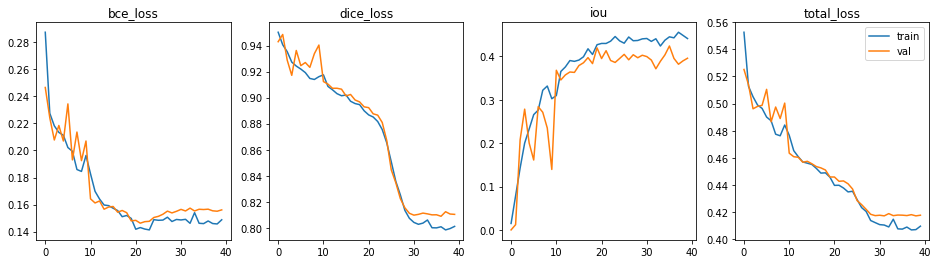

In [91]:
trainer.train_model(loader, num_epochs=40)

#### total_loss = bce_loss * 0.6 + dice_loss * (1 - 0.6)

### 7. Predictions

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce


def metrics_line(data):
    phases = list(data.keys())
    metrics = list(data[phases[0]][0].keys())

    i = 0
    fig, axs = plt.subplots(1, len(metrics))
    fig.set_figheight(4)
    fig.set_figwidth(4*len(metrics))
    for metric in metrics:
        for phase in phases:
            axs[i].plot([i[metric] for i in data[phase]], label=phase)
        axs[i].set_title(metric)
        i+=1

    plt.legend()
    plt.show()


def normalise_mask(mask, threshold=0.5):
    mask[mask > threshold] = 1
    mask[mask <= threshold] = 0
    return mask

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))
    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def plot_image_truemask_predictedmask2(images, labels, preds):

    input_images_rgb = [reverse_transform(x) for x in images]
    target_masks_rgb = [masks_to_coloredmasks(x) for x in labels]
    pred_masks_rgb   = [masks_to_coloredmasks(x) for x in preds]

    img_arrays = [input_images_rgb, target_masks_rgb, pred_masks_rgb]
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))
    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

def apply_mask_color(mask, mask_color):
    colored_mask = np.concatenate(([mask[ ... , np.newaxis] * color for color in mask_color]), axis=2)
    return colored_mask.astype(np.uint8)

def masks_to_coloredmasks(mask, normalise=True, colors=None):
    '''
    To assign colors to the different classes, for identification purpose only!
    '''
    segments_colors = np.asarray([(0, 255, 255), (0,0,255), (0, 255, 0), (255, 0, 0),(0, 0, 0)])
    if colors is not None:
        segments_colors = colors

    if normalise:
        normalise_mask(mask)

    mask_colored = np.concatenate( [ [apply_mask_color(mask[i], segments_colors[i])] for i in range(len(mask)) ] )
    mask_colored = np.max(mask_colored, axis=0)

    mask_colored = np.where(mask_colored.any(-1,keepdims=True),mask_colored,255)

    return mask_colored



torch.Size([4, 3, 224, 224]) torch.Size([4, 5, 224, 224]) (4, 5, 224, 224)


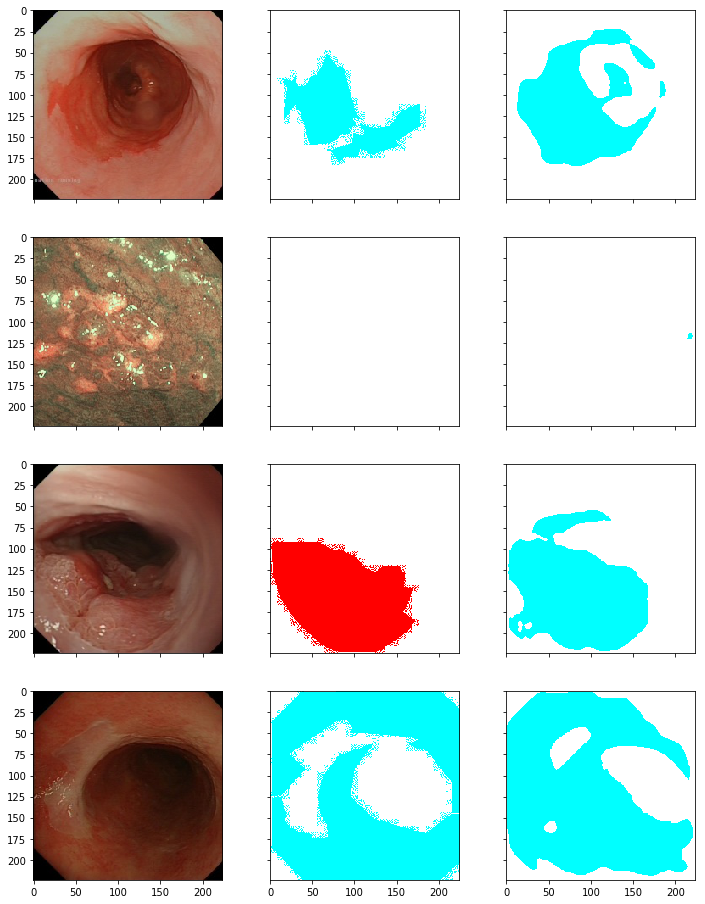

In [96]:
images, target = next(iter(loader['val']))#fetch the next batch of images and respective masks
preds = trainer.predict(images)
print(images.shape,target.shape,preds.shape)
plot_image_truemask_predictedmask2(images, target, preds)

## Other approaches  : 
--under construction.  
Modelling the distribution of each one of the RGB pixels of the image where the masks show positive


In [ ]:
all_sus = []
all_cancer = []
all_image = []
for batch in loader:
    image = batch[0][0]#torch.Size([3, 224, 224])
    mask = batch[1][0]
    be = mask[0]
    sus = mask[1]
    hgd = mask[2]
    cancer = mask[3]
    polyp = mask[4]
    all_image.append(image)
    all_cancer.append(cancer)
    all_sus.append(sus)
len(all_sus),len(all_cancer),len(all_image)

In [ ]:
cancer_index = []
cancer_coords= []
all_cancer = all_sus
for i,mask in enumerate(all_cancer):
    if np.argwhere(np.asarray(mask)>0).shape[0]!=0:
        cancer_index.append(i)
        cancer_coords.append(np.argwhere(np.asarray(mask)>0))
len(cancer_index)

In [ ]:
r_pixels = []
g_pixels = []
b_pixels = []
for index,coords in zip(cancer_index,cancer_coords):
    print(i,coords.shape)
    r=np.asarray(all_image[index][0])
    g=np.asarray(all_image[index][1])
    b=np.asarray(all_image[index][2])
    for coord in coords:
        r_pixels.append(r[coord[0]][coord[1]])
        g_pixels.append(g[coord[0]][coord[1]])
        b_pixels.append(b[coord[0]][coord[1]])

In [ ]:
len(r_pixels),len(g_pixels),len(b_pixels)

Suspicious_train

In [ ]:
import seaborn as sns
sns.set()
np.random.seed(0)
rx = sns.distplot(r_pixels)
gx = sns.distplot(g_pixels)
bx = sns.distplot(b_pixels)

Cancer_train

In [ ]:
import seaborn as sns
sns.set()
np.random.seed(0)
rx = sns.distplot(r_pixels)
gx = sns.distplot(g_pixels)
bx = sns.distplot(b_pixels)

Cancer_val

In [ ]:
import seaborn as sns
sns.set()
np.random.seed(0)
rx = sns.distplot(r_pixels)
gx = sns.distplot(g_pixels)
bx = sns.distplot(b_pixels)

Epoch 1/20:
	learning rate: 0.001
	train-> bce:0.344532|dice:0.953130|iou:0.023818|loss:0.648831


TypeError: step() missing 1 required positional argument: 'metrics'

In [ ]:
for batch_image,batch_mask in (loader['train']): #every iteration fetches data of size batchsize
    print('adfaf')
    print(batch_image.shape,batch_mask.shape)
    for image in batch_image:
        im = transforms.ToPILImage()(image).convert("RGB")
        display(im)
    

In [ ]:
type(dataset[0][0]),dataset[0][0].shape,type(dataset[0][1]),dataset[0][1].shape

In [ ]:
#TO GENERATE MASKS
t=dataset[5][1]
t=t.astype(np.float32)
for i in range(5):
    tx=t[i,:,:]
    tx=tx.reshape((1,)+tx.shape)
    tx=torch.from_numpy(tx)
    im=transforms.ToPILImage()(tx)
    display(im)

In [ ]:
t=dataset[0][0]
from torchvision import transforms
im = transforms.ToPILImage()(t).convert("RGB")
display(im)
print(im.size)

In [ ]:
#TO COMBINE ALL MULTIPLE MASKS INTO ONE
    
if __name__ == '__main__':
    import tifffile as tiff
    from tifffile import imsave
    import cv2
    import numpy as np
    import glob
    import os
    imgdir='./EDD2020/EDD2020_release-I_2020-01-15/originalImages/'
    maskdir='./EDD2020/EDD2020_release-I_2020-01-15/masks/'
    outputdir='./EDD2020/EDD2020_release-I_2020-01-15/outputdir/'
    
    os.makedirs(outputdir, exist_ok=True)
    
    categoryList = ['BE', 'suspicious', 'HGD' , 'cancer', 'polyp']
    
    ext = ['*.jpg']
    for filename in sorted(glob.glob(imgdir + '/'+ ext[0], recursive = True)):
        file=filename.split('/')[-1]
        fileNameOnly = file.split('.')[0]
        nClasses_annotated = len(glob.glob1(maskdir,fileNameOnly+"*.tif"))
        fileList = glob.glob1(maskdir,fileNameOnly+"*.tif")
       
        # read original and make stack of mask images
        image = cv2.imread(filename)
        height, width = image.shape[:2]
        mask = np.zeros([height, width, len(categoryList)], dtype=np.uint8)
        
        for i in range (0, nClasses_annotated):
            f = fileList[i].split('_')[-1]
            if f.split('.')[0] == 'BE':
                mask[:,:, 0] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0]== 'suspicious'):
                mask[:,:, 1] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0] == 'HGD'):
                mask[:,:, 2] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0] == 'cancer'):
                mask[:,:, 3] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0] == 'polyp'):
                mask[:,:, 4] = tiff.imread(os.path.join(maskdir,fileList[i]))
                
                
            im_mask = mask.transpose([2,0,1])    
            imsave(os.path.join(outputdir,fileNameOnly+'_mask.tif'), im_mask)      
            